In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler



1. Data Preprocessing:
Load the datasets


In [2]:
# Load the three datasets
average_hours = pd.read_csv('Resources/average-usual-weekly-hours-worked-women-15-years-and-older.csv')
employment_ratio = pd.read_csv("Resources/female-employment-to-population-ratio.csv")
wage_gap = pd.read_csv("Resources/gender-wage-gap-oecd.csv")
percapita_labor = pd.read_csv("Resources/female-labor-force-participation-rates-by-national-per-capita-income.csv")
school_years = pd.read_csv("Resources/mean-years-of-schooling-female.csv")
maternity_leave = pd.read_csv("Resources/paid-leave-at-least-14-weeks-mothers.csv")
labor_sector = pd.read_csv("Resources/share-of-female-workers-by-sector.csv")


In [3]:
# Columns and Rows for each of the dataset 
print(f'Shape of average_hours DataFrame: {average_hours.shape}')
print(f'Shape of employment_ratio DataFrame: {employment_ratio.shape}')
print(f'Shape of wage_gap DataFrame: {wage_gap.shape}')
print(f'Shape of percapita_labor DataFrame: {percapita_labor.shape}')
print(f'Shape of school_years DataFrame: {school_years.shape}')
print(f'Shape of maternity_leave DataFrame: {maternity_leave.shape}')
print(f'Shape of labor_sector DataFrame: {labor_sector.shape}')

Shape of average_hours DataFrame: (971, 4)
Shape of employment_ratio DataFrame: (3919, 4)
Shape of wage_gap DataFrame: (636, 4)
Shape of percapita_labor DataFrame: (7185, 6)
Shape of school_years DataFrame: (1502, 4)
Shape of maternity_leave DataFrame: (10206, 4)
Shape of labor_sector DataFrame: (2781, 6)


In [4]:
# Rename Columns to make it shorter
average_hours = average_hours.rename(columns={'Average weekly hours worked (women, 15+) (OECD Labor Force Statistics (2017))': 'Avg_Hours_Worked'})
employment_ratio = employment_ratio.rename(columns={'Employment to population ratio, 15+, female (%) (national estimate)': 'Emp_Pop_Ratio'})
wage_gap = wage_gap.rename(columns={'Gender wage gap (OECD 2017)': 'Gender_Wage_Gap'})
percapita_labor = percapita_labor.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)': 'Labor_Force'})
school_years = school_years.rename(columns={'Mean years of schooling (ISCED 1 or higher), population 25+ years, female': 'School_Years_Mean'})
maternity_leave = maternity_leave.rename(columns={'Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)': 'Paid_Leave'})
labor_sector = labor_sector.rename(columns={'Female share of employment in agriculture (%)': 'Argiculture','Female share of employment in industry (%)': 'Industry','Female share of employment in services (%)': 'Services'})


In [5]:
average_hours.dropna()
employment_ratio.dropna()

,Entity,Code,Year,Emp_Pop_Ratio
0,Afghanistan,AFG,2008,42.832
1,Afghanistan,AFG,2012,15.481
2,Afghanistan,AFG,2014,23.177
3,Afghanistan,AFG,2017,18.202
4,Afghanistan,AFG,2020,13.730
...,...,...,...,...
3914,Zimbabwe,ZWE,2011,72.826
3915,Zimbabwe,ZWE,2012,52.350
3916,Zimbabwe,ZWE,2014,76.099
3917,Zimbabwe,ZWE,2019,56.447


In [6]:
# Merge the datasets
merged_df= average_hours.merge(employment_ratio, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(wage_gap, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(percapita_labor, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(school_years, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(maternity_leave, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(labor_sector, on=['Entity', 'Code', 'Year'], how='outer')

# Check the result
print(merged_df.shape)


(11529, 14)


In [7]:
#Drop colum "Continent"
merged_df = merged_df.drop("Continent", axis=1)

In [8]:
# Check for duplicates
duplicates = merged_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


In [9]:
# Check the data types of each column
print(merged_df.dtypes)


Entity                                                  object
Code                                                    object
Year                                                     int64
Avg_Hours_Worked                                       float64
Emp_Pop_Ratio                                          float64
Gender_Wage_Gap                                        float64
Labor_Force                                            float64
GDP per capita, PPP (constant 2017 international $)    float64
School_Years_Mean                                      float64
Paid_Leave                                             float64
Argiculture                                            float64
Industry                                               float64
Services                                               float64
dtype: object


In [10]:
# Perform some basic EDA
print(merged_df.describe())


               Year  Avg_Hours_Worked  Emp_Pop_Ratio  Gender_Wage_Gap  \
count  11529.000000        971.000000    3919.000000       636.000000   
mean    1997.412959         35.869809      44.636617        19.385535   
std       15.463656          4.349991      14.213520        10.053530   
min     1960.000000         24.038079       2.500000         0.000000   
25%     1984.000000         32.769731      37.049000        13.200000   
50%     1998.000000         35.785293      46.048000        17.900000   
75%     2011.000000         38.961367      52.876500        23.400000   
max     2023.000000         51.027365      94.500000        52.800000   

       Labor_Force  GDP per capita, PPP (constant 2017 international $)  \
count  6431.000000                                        6562.000000     
mean     49.584312                                       18307.128922     
std      15.370705                                       20344.959620     
min       4.948000                        

In [11]:
# Check for null values
print(merged_df.isnull().sum())

Entity                                                     0
Code                                                     587
Year                                                       0
Avg_Hours_Worked                                       10558
Emp_Pop_Ratio                                           7610
Gender_Wage_Gap                                        10893
Labor_Force                                             5098
GDP per capita, PPP (constant 2017 international $)     4967
School_Years_Mean                                      10027
Paid_Leave                                              1323
Argiculture                                             8804
Industry                                                8782
Services                                                8784
dtype: int64


In [12]:
# Define numerical and catrgorical columns 
numerical_cols = ['Year', 'Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

categorical_cols = ['Entity', 'Code']

In [13]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Impute null values in numerical columns using KNNImputer
imputer_num = KNNImputer(n_neighbors=5)
imputed_num_data = imputer_num.fit_transform(merged_df[numerical_cols])

# One-Hot Encode categorical columns
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_array = ohe.fit_transform(merged_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_array.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

# Concatenate imputed numerical columns with one-hot encoded categorical columns
df_encoded = pd.concat([pd.DataFrame(imputed_num_data, columns=numerical_cols), encoded_df], axis=1)

In [14]:
# Impute null values in numerical columns using KNNImputer
from sklearn.impute import KNNImputer
imputer_num = KNNImputer(n_neighbors=5)

# Check for null values before imputation
print("Null values before imputation:")
print(merged_df[numerical_cols].isnull().sum())

imputed_num_data = imputer_num.fit_transform(merged_df[numerical_cols])

# Check imputed data for null values
imputed_num_df = pd.DataFrame(imputed_num_data, columns=numerical_cols)
print("Null values after imputation:")
print(imputed_num_df.isnull().sum())


Null values before imputation:
Year                                                       0
Avg_Hours_Worked                                       10558
Emp_Pop_Ratio                                           7610
Gender_Wage_Gap                                        10893
Labor_Force                                             5098
GDP per capita, PPP (constant 2017 international $)     4967
School_Years_Mean                                      10027
Paid_Leave                                              1323
Argiculture                                             8804
Industry                                                8782
Services                                                8784
dtype: int64
Null values after imputation:
Year                                                   0
Avg_Hours_Worked                                       0
Emp_Pop_Ratio                                          0
Gender_Wage_Gap                                        0
Labor_Force                

In [15]:
# Assign imputed values back to the original DataFrame (optional)
merged_df[numerical_cols] = imputed_num_df

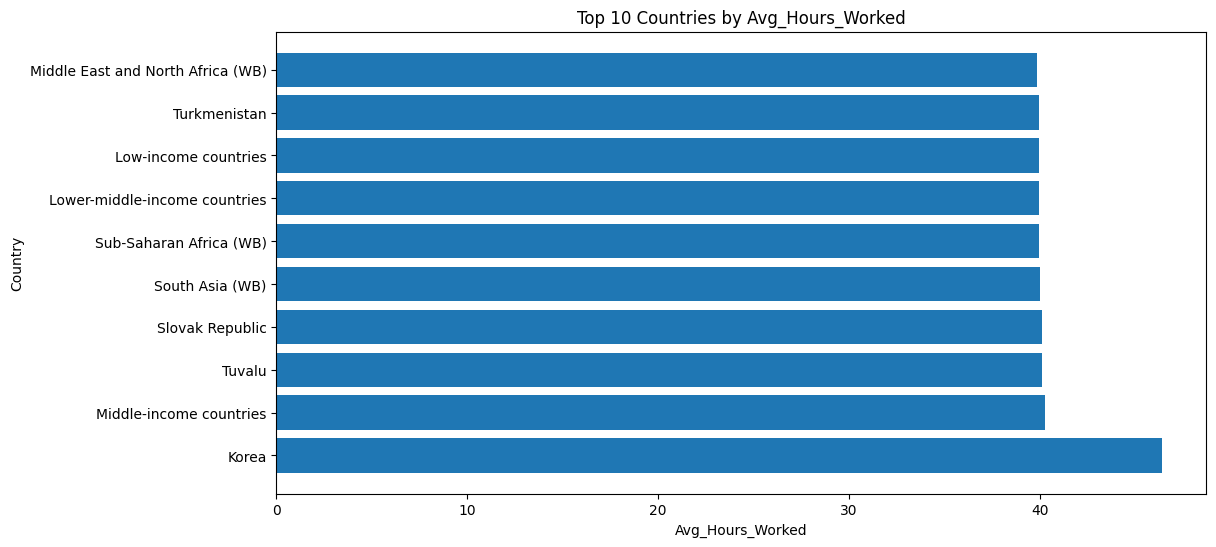

In [16]:
# Get the top 10 countries by Average Hours Worked  
top_countries = merged_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Avg_Hours_Worked'])
plt.title("Top 10 Countries by Avg_Hours_Worked")
plt.xlabel("Avg_Hours_Worked")
plt.ylabel("Country")
plt.show()

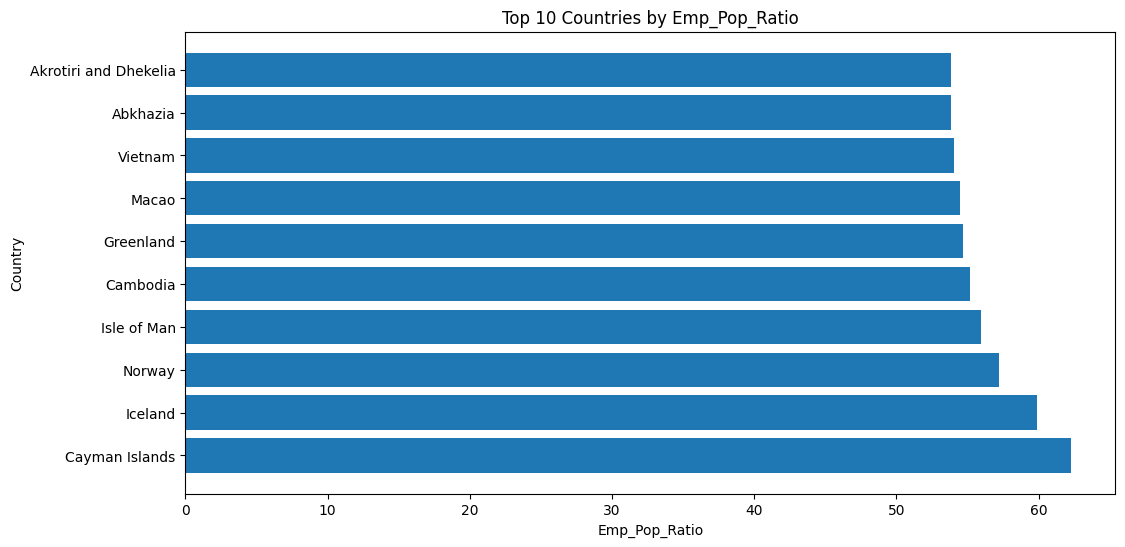

In [17]:
# Get the top 10 countries by Emp_Pop_Ratio  
top_countries = merged_df.groupby('Entity')['Emp_Pop_Ratio'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Emp_Pop_Ratio')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Emp_Pop_Ratio'])
plt.title("Top 10 Countries by Emp_Pop_Ratio")
plt.xlabel("Emp_Pop_Ratio")
plt.ylabel("Country")
plt.show()

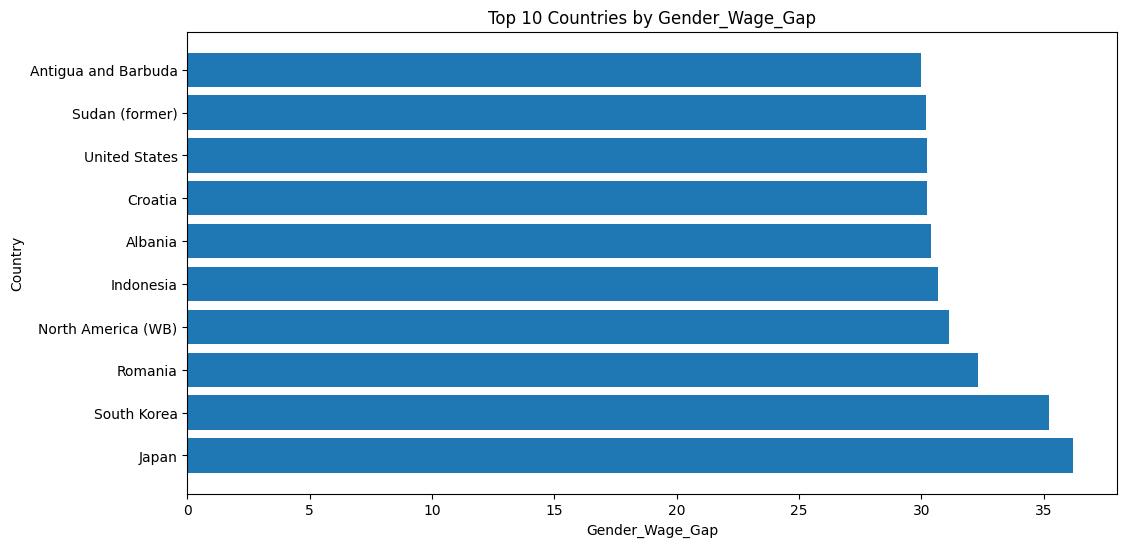

In [18]:
# Get the top 10 countries by Gender_Wage_Gap
top_countries = merged_df.groupby('Entity')['Gender_Wage_Gap'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Gender_Wage_Gap')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Gender_Wage_Gap'])
plt.title("Top 10 Countries by Gender_Wage_Gap")
plt.xlabel("Gender_Wage_Gap")
plt.ylabel("Country")
plt.show()

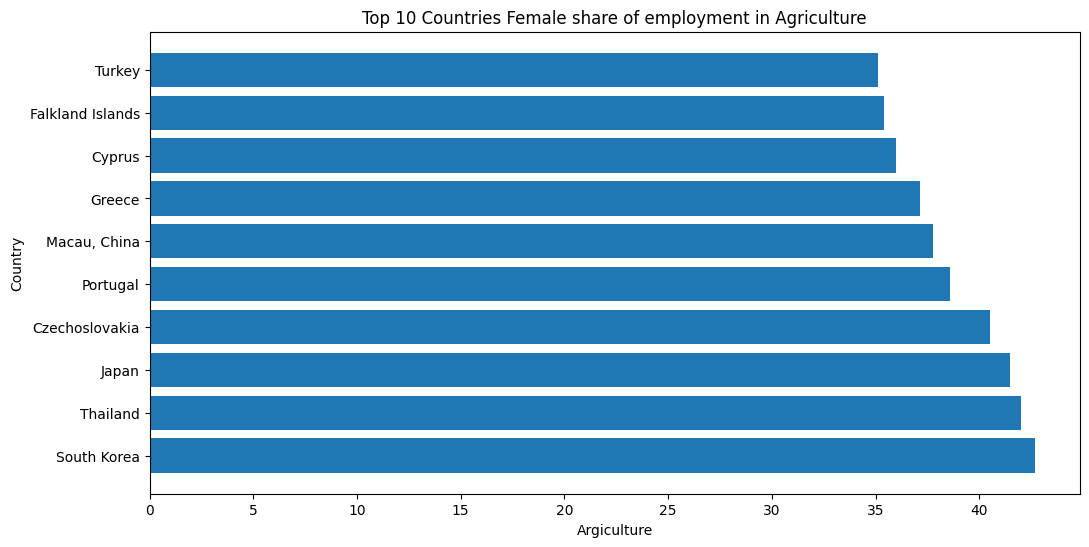

In [19]:
# Get the top 10 countries by Argiculture
top_countries = merged_df.groupby('Entity')['Argiculture'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Argiculture')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Argiculture'])
plt.title("Top 10 Countries Female share of employment in Agriculture")
plt.xlabel("Argiculture")
plt.ylabel("Country")
plt.show()

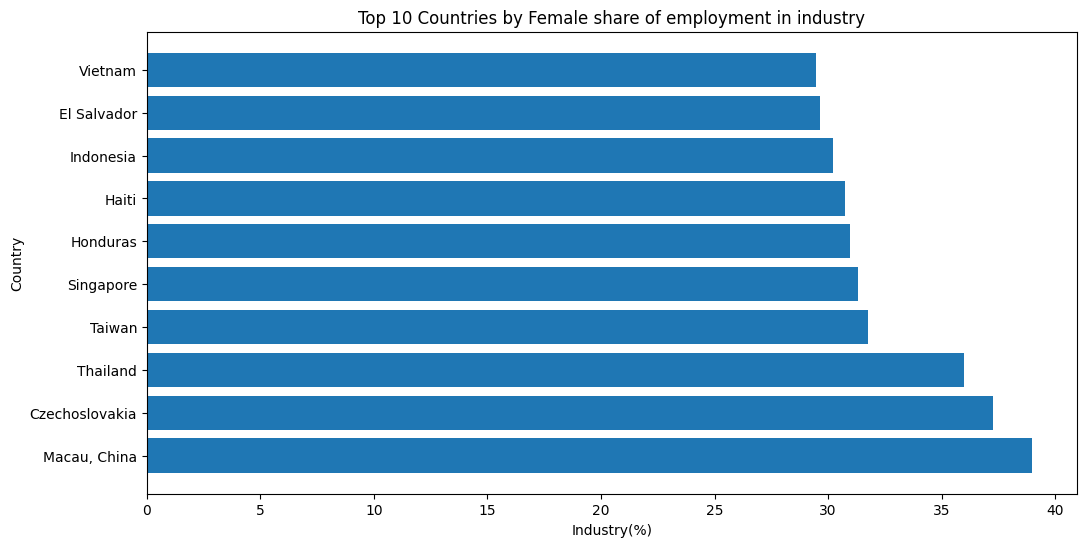

In [20]:
# Get the top 10 countries by Industry
top_countries = merged_df.groupby('Entity')['Industry'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Industry')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Industry'])
plt.title("Top 10 Countries by Female share of employment in industry")
plt.xlabel("Industry(%)")
plt.ylabel("Country")
plt.show()

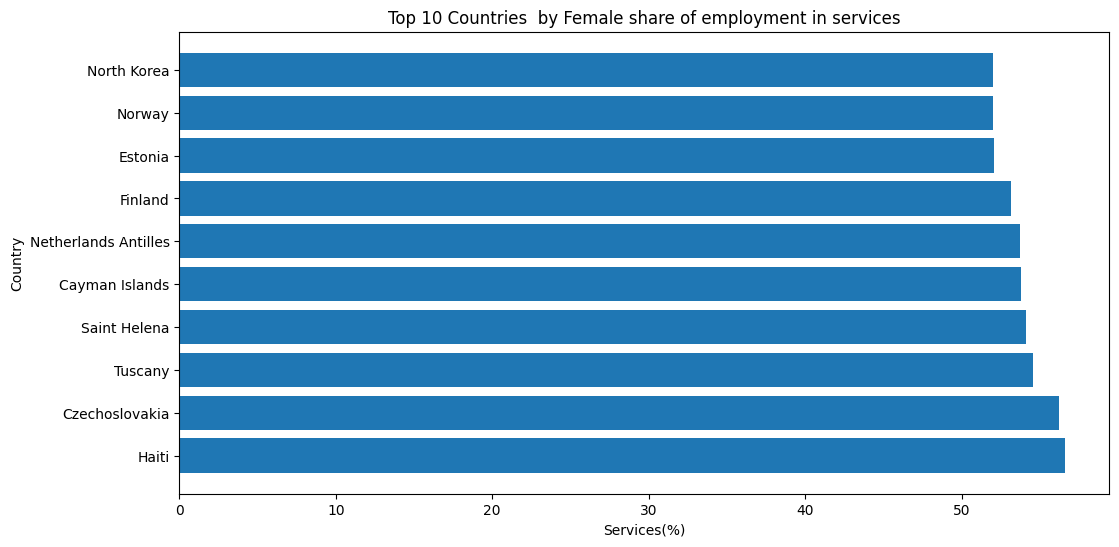

In [21]:
# Get the top 10 countries by Services
top_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Services'])
plt.title("Top 10 Countries  by Female share of employment in services")
plt.xlabel("Services(%)")
plt.ylabel("Country")
plt.show()

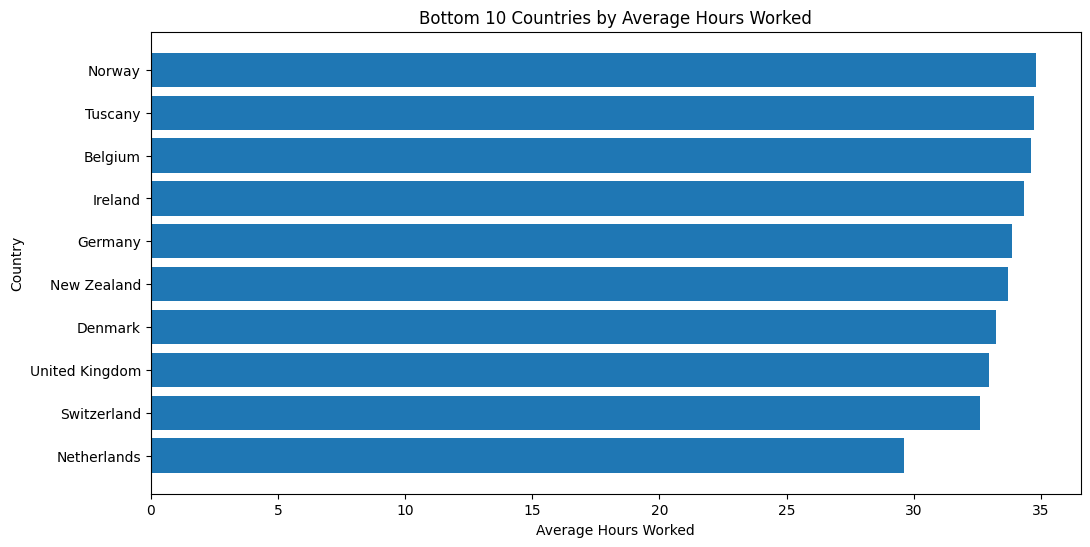

In [22]:

# Get the bottom 10 countries by average hours worked
bottom_countries = merged_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Avg_Hours_Worked'])
plt.title("Bottom 10 Countries by Average Hours Worked")
plt.xlabel("Average Hours Worked")
plt.ylabel("Country")
plt.show()

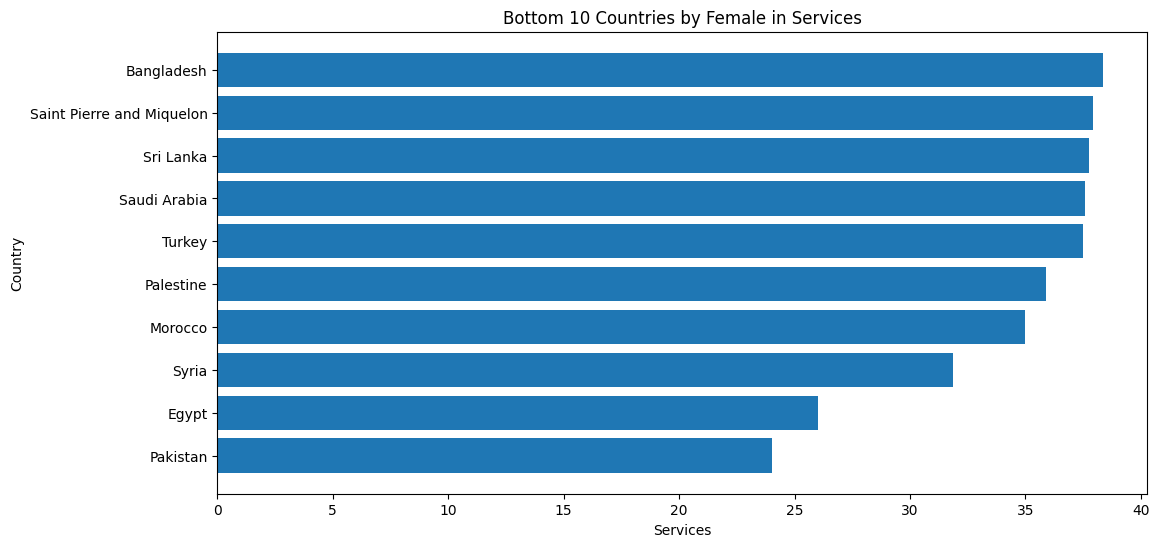

In [23]:
# Get the top 10 countries by Services
bottom_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Services'])
plt.title("Bottom 10 Countries by Female in Services")
plt.xlabel("Services")
plt.ylabel("Country")
plt.show()

In [24]:
# Check for null values
print(merged_df.isnull().sum())

Entity                                                   0
Code                                                   587
Year                                                     0
Avg_Hours_Worked                                         0
Emp_Pop_Ratio                                            0
Gender_Wage_Gap                                          0
Labor_Force                                              0
GDP per capita, PPP (constant 2017 international $)      0
School_Years_Mean                                        0
Paid_Leave                                               0
Argiculture                                              0
Industry                                                 0
Services                                                 0
dtype: int64


In [25]:
merged_df

,Entity,Code,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services
0,Abkhazia,OWID_ABK,2015.0,35.146454,53.832952,14.78,45.9662,17149.51152,6.832154,0.4,32.242,23.402,44.772
1,Afghanistan,AFG,1970.0,34.954374,39.262400,44.66,57.1420,6244.07698,5.464494,0.0,22.872,21.256,34.526
2,Afghanistan,AFG,1971.0,34.954374,38.660000,44.66,57.1420,6244.07698,2.622106,0.0,36.676,27.292,39.274
3,Afghanistan,AFG,1972.0,34.954374,45.000800,44.66,55.9014,6244.07698,3.322344,0.0,36.496,31.310,43.682
4,Afghanistan,AFG,1973.0,34.954374,34.724800,42.74,55.9014,6244.07698,1.540688,0.0,30.746,22.934,39.590
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11524,Zimbabwe,ZWE,2019.0,37.708588,56.447000,22.62,60.7300,2203.39670,8.070020,1.0,28.060,18.850,52.726
11525,Zimbabwe,ZWE,2020.0,37.708588,53.195600,22.80,59.8480,1990.31950,11.204198,1.0,26.126,18.850,52.726
11526,Zimbabwe,ZWE,2021.0,37.708588,54.094000,29.26,60.1470,2115.14450,9.139034,1.0,30.412,21.302,52.120
11527,Zimbabwe,ZWE,2022.0,37.708588,52.919000,22.80,60.0720,2207.95700,10.599860,1.0,29.412,16.504,52.700


In [27]:
# Step 1: Define the professional score range and create a new column in the DataFrame
merged_df['Professional_Score'] = (merged_df['Avg_Hours_Worked'] - merged_df['Avg_Hours_Worked'].min()) / (merged_df['Avg_Hours_Worked'].max() - merged_df['Avg_Hours_Worked'].min())

# Step 2: Preprocess the data
# Scaling/normalizing numerical features
numerical_features = ['Avg_Hours_Worked', 'Emp_Pop_Ratio', 'GDP per capita, PPP (constant 2017 international $)', 'School_Years_Mean']
scaler = StandardScaler()
merged_df[numerical_features] = scaler.fit_transform(merged_df[numerical_features])

# Encoding categorical features
categorical_features = ['Code', 'Entity']
encoder = OneHotEncoder()
merged_df[categorical_features] = encoder.fit_transform(merged_df[categorical_features])

# Splitting the data into training and testing sets
X = merged_df.drop('Professional_Score', axis=1)
y = merged_df['Professional_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a machine learning model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Step 4: Use the trained model to predict the professional scores for each country in the DataFrame
merged_df['Predicted_Professional_Score'] = model.predict(merged_df)

ValueError: Columns must be same length as key